In [11]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib, collections
from scipy.stats import norm
import imp, os, pickle
import warnings
import sys
import math
from matplotlib import collections  as mc
from scipy.stats import poisson
warnings.filterwarnings("ignore")
from scipy.stats import norm
sns.set(style="white")
colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

## Parameters

In [12]:
f = 0.1 #Mining rate
m = 200 #Number of voting chains
log_epsilon = 20 #Confirmation guarantee

'''
Number of public proposal block
proposer_block[0] is mined by honest node, proposer_block[1] is mined by adversarial node
proposer_block[0] is A in the report, proposer_block[1] is B in the report
'''
proposer_blocks = 2 

beta_actual = 0.1 # probability with which an incoming voting block has been mined by adversary

'''
probability of choosing proposal block A and B, respectively, by honest nodes.
'''
prob_selecting_proposer_blocks_by_honest_nodes = [0.4, 0.6] 


beta_calc = np.array([0.1, 0.15, 0.2, 0.25, .3, .35, 0.4]) # probability using which V_estimate is calculated

## Prism Latency Simulation

In [13]:
# Number of adverserial blocks in private at time t
'''
def adverserial(t, beta, fv):
    x = np.arange(0,1000,1)
    mu = fv*t*beta/(1-beta)
    return poisson.pmf(x, mu)
'''


#Probability that a vote for with depth k will be removed when adversary has Z_t blocks in the 
'''
def p_k_t(k, Z_t,beta):
    ans = 0
    k = int(k)
    # print(k)
    for i in range(k):
        ans += Z_t[i]*np.power(beta/(1-beta), k - i)
    ans += np.sum(Z_t[k:])
    return ans
'''
def p_k_t(k, Z_t, beta):
    if k >= Z_t:
        ans = np.power(beta/(1-beta), k - Z_t)
    else:
        ans = 1
    return ans


def runExp(m, log_epsilon, fv, proposer_blocks, prob_selecting_proposer_blocks_by_honest_nodes, beta_calc, beta_actual):
    events = int(20000*log_epsilon)
    time_array = np.zeros_like(beta_calc)
    fv_effective = fv/(1.0+2*fv) #Forking
    exp_random_v = np.random.exponential(1/(m*fv_effective), size=events)
    chain_random_v = np.random.randint(m, size=events)
    
    
    '''
    Determining whether the mined block at each event is from an honest node or from an adversary
    Each element is associated with an event of mining a block 
    Each element specifies whether the block is mined by adversary or honest node
    '''
    mined_by_adversary_or_honest_node = np.random.choice(['Honest', 'Adversary'], events, p = [1 - beta_actual, beta_actual])
    

    
    for j, beta in enumerate(beta_calc):
#         exponent = 0.8*(1-2*beta)/(1-beta)*np.log((1-beta)/beta)

        print('beta')
        print(beta)
        
        # the following variables are used for the computation of \underbar{V}_{n}(r)
        votes_permanence_E_A, votes_permanence_V_A =  np.zeros(m),  np.zeros(m)
        time, mean_A, var_A  = 0,0,0
        votes_permanence_E_B, votes_permanence_V_B =  np.zeros(m),  np.zeros(m)
        mean_B, var_B  = 0,0        
        
            
        '''
        The following vector contains proposal block voted by each of the voter chain
        It can be updated everytime a voter block is mined 
        (specifically, in case of tie in length of competing forked chains)
        Initially, no voter block has been mined and so no voting yet, thus, initializing with None
        If proposal_block_selected_by_voter_chain[rChain] = 0, then vote is for A
        If proposal_block_selected_by_voter_chain[rChain] = 1, then vote is for B
        '''
        proposal_block_selected_by_voter_chain = np.asarray([None]*m) 


        '''
        n_A is the number of votes for A in a chain along the voting tree
        n_B is the number of votes for B in a chain along the voting tree
        Initially, no votes cast, so, initialized with 0
        '''
        n_A = np.zeros(m)
        n_B = np.zeros(m)
        
        
        
        
        
        for i, tDiff in enumerate(exp_random_v):
            # print(i)
            # incrementing time
            time += tDiff
            
            
            # Selecting the chain to add the voting block (by sortition)
            rChain = chain_random_v[i]
            
            
            '''
            (1) Determining whether adversary mined the block or honest node mined the block
            (2) Determining where the vote gets added among the two competing forked voter chains
            '''
            if mined_by_adversary_or_honest_node[i] == 'Adversary':                    
                # block mined by adversary votes for the shorter of the chain
                # the adversary doesn't change the vote
                if n_A[rChain] > n_B[rChain]:
                    n_B[rChain] += 1
                elif n_A[rChain] < n_B[rChain]:
                    n_A[rChain] += 1
                else:
                    '''
                    The case for n_A[rChain] = n_B[rChain]
                    The adversary would try to balance the total number of votes 
                    '''                    
                    number_of_votes_for_A_currently = np.count_nonzero(proposal_block_selected_by_voter_chain == 0)
                    number_of_votes_for_B_currently = np.count_nonzero(proposal_block_selected_by_voter_chain == 1)
                    
                    # Balance the number of votes for the proposer blocks
                    if number_of_votes_for_A_currently > number_of_votes_for_B_currently:
                        proposal_block_selected_by_voter_chain[rChain] = 1
                        n_B[rChain] += 1
                    elif number_of_votes_for_A_currently < number_of_votes_for_B_currently:
                        proposal_block_selected_by_voter_chain[rChain] = 0
                        n_A[rChain] += 1
                    else: 
                        # Do nothing
                        pass
                
            else:
                # If mined by honest node, then we have following cases
                if n_A[rChain] > n_B[rChain]:
                    # Applying longest chain protocol
                    n_A[rChain] += 1
                elif n_A[rChain] < n_B[rChain]:
                    # Applying longest chain protocol
                    n_B[rChain] += 1
                else:
                    '''
                    The case for n_A[rChain] = n_B[rChain]
                    In globalised view, count the number of votes that A and B have obtained till now 
                    '''
                    number_of_votes_for_A_currently = np.count_nonzero(proposal_block_selected_by_voter_chain == 0)
                    number_of_votes_for_B_currently = np.count_nonzero(proposal_block_selected_by_voter_chain == 1)
                    
                    # follow maximum vote protocol
                    if number_of_votes_for_A_currently > number_of_votes_for_B_currently:
                        proposal_block_selected_by_voter_chain[rChain] = 0
                        n_A[rChain] += 1
                    elif number_of_votes_for_A_currently < number_of_votes_for_B_currently: 
                        proposal_block_selected_by_voter_chain[rChain] = 1
                        n_B[rChain] += 1
                    else:
                        # random selection, a not so often scenario (not sure whether it is rare)
                        proposal_block_selected_by_voter_chain[rChain] = np.random.choice([0, 1], 1, p = prob_selecting_proposer_blocks_by_honest_nodes)
                        if proposal_block_selected_by_voter_chain[rChain] == 0:
                            n_A[rChain] += 1
                        else:
                            n_B[rChain] += 1
                            
             
            
            
            
            '''
            Updating underbar_V_A
            '''
            # the length of the forked voter chain is given by n_B[rChain]
            p_i_A = 1 - p_k_t(n_A[rChain], n_B[rChain], beta)                
              
            # Updating the mean and variance
            mean_A -= votes_permanence_E_A[rChain]
            var_A  -= votes_permanence_V_A[rChain]            
            votes_permanence_E_A[rChain] = p_i_A  
            votes_permanence_V_A[rChain] = p_i_A*(1-p_i_A)            
            mean_A += votes_permanence_E_A[rChain]
            var_A  += votes_permanence_V_A[rChain]            
            
            underbar_V_A = mean_A - np.sqrt(2*var_A*log_epsilon)  
            # print("underbar_V_A: {0:8.2f}".format(underbar_V_A))
            
            
            #----------------------------------------------------------------
            # This is for sanity check, ignore
            if math.isnan(underbar_V_A) == True:
                print("mean_A: {0:8.2f}".format(mean_A))
                print("var_A: {0:8.2f}".format(var_A))
                sys.exit()
            #----------------------------------------------------------------

            '''
            Updating underbar_V_B
            '''
            # the length of the forked voter chain is given by n_A[rChain]
            p_i_B = 1 - p_k_t(n_B[rChain], n_A[rChain], beta)                
              
            # Updating the mean and variance
            mean_B -= votes_permanence_E_B[rChain]
            var_B  -= votes_permanence_V_B[rChain]            
            votes_permanence_E_B[rChain] = p_i_B  
            votes_permanence_V_B[rChain] = p_i_B*(1-p_i_B)            
            mean_B += votes_permanence_E_B[rChain]
            var_B  += votes_permanence_V_B[rChain]            
            
            underbar_V_B = mean_B - np.sqrt(2*var_B*log_epsilon)              
            # print("underbar_V_B: {0:8.2f}".format(underbar_V_B))
    
    
    
            #----------------------------------------------------------------
            # This is for sanity check, ignore
            if math.isnan(underbar_V_B) == True:
                print("mean_B: {0:8.2f}".format(mean_B))
                print("var_B: {0:8.2f}".format(var_B))  
                sys.exit()
            #----------------------------------------------------------------
            
            
            # counting number of voter chains that haven't cast vote for any proposal block
            U_current = np.count_nonzero(proposal_block_selected_by_voter_chain == None)
            
            # counting number of voter chains that currently casts vote for proposal block A
            V_A_current = np.count_nonzero(proposal_block_selected_by_voter_chain == 0) 
            
            
            # counting number of voter chains that currently casts vote for proposal block B
            V_B_current = np.count_nonzero(proposal_block_selected_by_voter_chain == 1)             
            
            
            '''
            Updating overbar_V_A
            '''
            overbar_V_A = V_A_current + (V_B_current - max(underbar_V_B , 0)) + U_current
            # print("overbar_V_A: {0:8.2f}".format(overbar_V_A))
 

            #----------------------------------------------------------------
            # This is for sanity check, ignore
            if math.isnan(overbar_V_A) == True:
                print("V_A_current: {0:8.2f}".format(V_A_current))
                print("V_B_current: {0:8.2f}".format(V_B_current))
                print("U_current: {0:8.2f}".format(U_current))
                print("underbar_V_B: {0:8.2f}".format(underbar_V_B))
                sys.exit()
            #----------------------------------------------------------------


            '''
            Updating overbar_V_B
            '''
            overbar_V_B = V_B_current + (V_A_current - max(underbar_V_A , 0)) + U_current
            # print("overbar_V_B: {0:8.2f}".format(overbar_V_B))
 

            #----------------------------------------------------------------
            # This is for sanity check, ignore
            if math.isnan(overbar_V_B) == True:
                print("V_A_current: {0:8.2f}".format(V_A_current))
                print("V_B_current: {0:8.2f}".format(V_B_current))
                print("U_current: {0:8.2f}".format(U_current))
                print("underbar_V_A: {0:8.2f}".format(underbar_V_A))
                sys.exit()
            #----------------------------------------------------------------


            
            # Confirmation policy
            if underbar_V_A > overbar_V_B:
                print('A is confirmed')
                time_array[j] = time
                print("Time: {0:8.2f}".format(time))
                break
            elif underbar_V_B > overbar_V_A:
                print('B is confirmed')
                time_array[j] = time
                print("Time: {0:8.2f}".format(time))
                break   
            else:
                # continue to next event
                pass 
            
            
            
    return time_array


prism_ans = np.zeros_like(beta_calc)
#T1: Time taken for a unique proposer block to refer the tx_block
prism_ans += np.power(np.e, 1*f)/f

#T2: Time taken for a proposer block to get confirmed
no_exp = 5
for i in range(no_exp):
    prism_ans += runExp(m, log_epsilon, f, proposer_blocks, prob_selecting_proposer_blocks_by_honest_nodes, beta_calc, beta_actual)
prism_ans /= no_exp

beta
0.1
A is confirmed
Time:    13.34
beta
0.15
A is confirmed
Time:    15.60
beta
0.2
B is confirmed
Time:    19.26
beta
0.25
A is confirmed
Time:    22.59
beta
0.3
B is confirmed
Time:    27.86
beta
0.35
B is confirmed
Time:    34.95
beta
0.4
A is confirmed
Time:    54.22
beta
0.1
B is confirmed
Time:    14.36
beta
0.15
A is confirmed
Time:    16.14
beta
0.2
B is confirmed
Time:    20.99
beta
0.25
B is confirmed
Time:    25.61
beta
0.3
B is confirmed
Time:    30.00
beta
0.35
B is confirmed
Time:    40.48
beta
0.4
A is confirmed
Time:    59.43
beta
0.1
A is confirmed
Time:    15.59
beta
0.15
A is confirmed
Time:    18.70
beta
0.2
A is confirmed
Time:    20.85
beta
0.25
B is confirmed
Time:    25.16
beta
0.3
B is confirmed
Time:    29.50
beta
0.35
A is confirmed
Time:    39.86
beta
0.4
B is confirmed
Time:    56.86
beta
0.1
A is confirmed
Time:    13.97
beta
0.15
B is confirmed
Time:    15.90
beta
0.2
B is confirmed
Time:    19.75
beta
0.25
A is confirmed
Time:    22.43
beta
0.3
B is 

## Bitcoin Latency calculation

In [14]:
exponent = 0.8*(1-2*beta_calc)/(1-beta_calc)*np.log((1-beta_calc)/beta_calc)
bitcoin_ans= (log_epsilon+np.log2(150))/(exponent*f)

## Plot

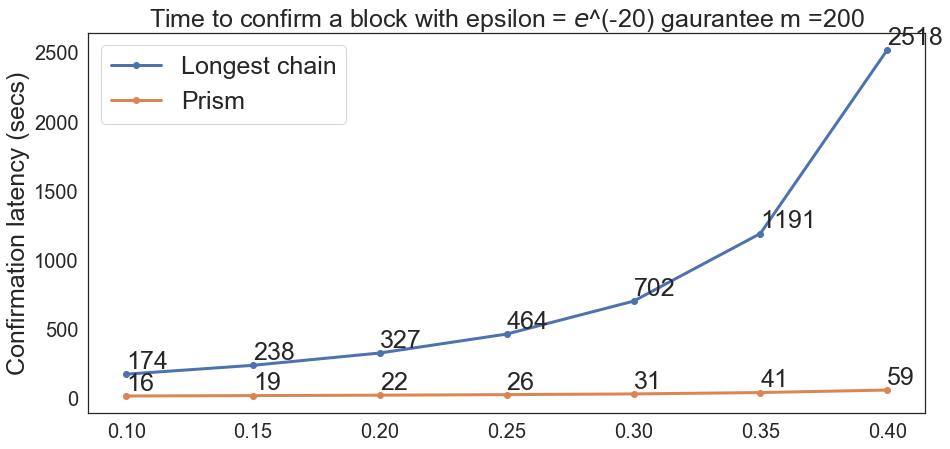

In [15]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)

bitcoin_ans = bitcoin_ans.astype(int)
prism_ans = prism_ans.astype(int)
plt.plot(beta_calc, bitcoin_ans, '-o', lw=3, label="Longest chain")
plt.plot(beta_calc, prism_ans, '-o',lw=3, label="Prism")
for i in range(bitcoin_ans.shape[0]):
    ax.annotate(bitcoin_ans[i],xy=(beta_calc[i],bitcoin_ans[i]+40), size=25)
    ax.annotate(prism_ans[i],xy=(beta_calc[i],prism_ans[i]+40), size=25)
plt.ylabel("Confirmation latency (secs)", size=25)
# plt.xlabel("Beta", size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title("Time to confirm a block with epsilon = $e$^("+str(-log_epsilon)+") gaurantee m ="+str(m), size=25)
plt.legend(prop={'size': 25})
plt.show()


In [146]:
import sys
k = 10
for i in range(k):
    if (1>2):
        sys.exit()

In [209]:
max(2 , 2)

2